# Exploring Conversation Chains and Memory with LCEL

## Install OpenAI, and LangChain dependencies

In [2]:
!pip install -q langchain==0.3.11
!pip install -q langchain-openai==0.2.12
!pip install -q langchain-community==0.3.11
!pip install -q langchain-chroma==0.1.4

  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      + d:\2. My WorkSpace and Notes\1. Demystify Folders\GenerativeAI-Demystified\.venv\Scripts\python.exe C:\Users\Sourav Banerjee\AppData\Local\Temp\pip-install-uzfr5ib2\numpy_92862ec9007a4ce2b727d3b79d97b081\vendored-meson\meson\meson.py setup C:\Users\Sourav Banerjee\AppData\Local\Temp\pip-install-uzfr5ib2\numpy_92862ec9007a4ce2b727d3b79d97b081 C:\Users\Sourav Banerjee\AppData\Local\Temp\pip-install-uzfr5ib2\numpy_92862ec9007a4ce2b727d3b79d97b081\.mesonpy-s6vb8p1l -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\Sourav Banerjee\AppData\Local\Temp\pip-install-uzfr5ib2\numpy_92862ec9007a4ce2b727d3b79d97b081\.mesonpy-s6vb8p1l\meson-python-native-file.ini
      The Meson build system
      Version: 1.2.99
      Source dir: C:\Users\Sourav Banerjee\AppData\Local\Temp\pip-install-uzfr5ib2\numpy_92862ec9007a4ce

## Enter Open AI API Key

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from getpass import getpass

# OPENAI_KEY = getpass('Enter Open AI API Key: ')
OPENAI_KEY = os.getenv("OPENAI_API_KEY")

## Setup Environment Variables

In [4]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

## Load Connection to LLM

Here we create a connection to ChatGPT to use later in our chains

In [5]:
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model_name='gpt-4o-mini', temperature=0)

## Working with LangChain Chains

Using an LLM in isolation is fine for simple applications, but more complex applications require chaining LLMs - either with each other or with other components. Also running on multiple data points can be done easily with chains.

Chain's are the legacy interface for "chained" applications. We define a Chain very generically as a sequence of calls to components, which can include other chains.

Here we will be using LCEL chains exclusively

### The Problem with Simple LLM Chains

Simple LLM Chains cannot keep a track of past conversation history

In [6]:
from langchain_core.prompts import ChatPromptTemplate

prompt_txt = """{query}"""
prompt = ChatPromptTemplate.from_template(prompt_txt)

# you can also write this as llm_chain = prompt | chatgpt
llm_chain = (
    prompt
      |
    chatgpt
)

In [7]:
response = llm_chain.invoke({'query': 'What are the first four colors of a rainbow?'})
print(response.content)

The first four colors of a rainbow are red, orange, yellow, and green.


In [8]:
response = llm_chain.invoke({'query': 'and the other 3?'})
print(response.content)

It seems like your question might be missing some context. Could you please provide more details or clarify what you are referring to with "the other 3"? This will help me assist you better!


### Conversation Chains with LCEL

LangChain Expression Language (LCEL) connects prompts, models, parsers and retrieval components using a `|` pipe operator.

A conversation chain basically consists of user prompts, historical conversation memory and the LLM. The LLM uses the history memory to give more contextual answers to every new prompt or user query.

Memory is very important for having a true conversation with LLMs. LangChain allows us to manage conversation memory using various constructs. The main ones we will cover include:

- ConversationBufferMemory
- ConversationBufferWindowMemory
- ConversationSummaryMemory
- VectorStoreRetrieverMemory
- ChatMessageHistory
- SQLChatMessageHistory

### Conversation Chains with ConversationBufferMemory

This is the simplest version of in-memory storage of historical conversation messages. It is basically a buffer for storing conversation memory.

Remember if you have a really long conversation, you might exceed the max token limit of the context window allowed for the LLM.

In [9]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.memory import ConversationBufferMemory
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda

SYS_PROMPT = """Act as a helpful assistant and give brief answers"""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{query}"),
    ]
)

memory = ConversationBufferMemory(return_messages=True)

C:\Users\Sourav Banerjee\AppData\Local\Temp\ipykernel_45028\3875846320.py:14: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(return_messages=True)


In [10]:
# function to get historical conversation messages from the memory
memory.load_memory_variables({})

{'history': []}

### Understand RunnableLambda
https://python.langchain.com/api_reference/core/runnables/langchain_core.runnables.base.RunnableLambda.html

In [11]:
def sum(a):
    return a + 3
# 
RunnableLambda(sum).invoke(4)

7

In [12]:
def add_one(x: int) -> int:
    return x + 1

RunnableLambda(add_one).invoke(1)

2

In [13]:
type(RunnableLambda(add_one))

langchain_core.runnables.base.RunnableLambda

In [14]:
for elem in RunnableLambda(add_one).stream(2):
    print(elem)

3


In [15]:
for elem in RunnableLambda(add_one).batch([1,2,3]):
    print(elem)

2
3
4


### Understand RunnablePassthrough
https://python.langchain.com/api_reference/core/runnables/langchain_core.runnables.passthrough.RunnablePassthrough.html

In [16]:
from langchain_core.runnables import (
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)

runnable = RunnableParallel(
    origin=RunnablePassthrough(),
    modified=lambda x: x+1
)

runnable.invoke(1)

{'origin': 1, 'modified': 2}

In [17]:
def fake_llm(prompt: str) -> str: # Fake LLM for the example
    return "completion"

chain = RunnableLambda(fake_llm) | {
    'original': RunnablePassthrough(), # Original LLM output
    'parsed': lambda text: text[::-1] # Parsing logic
}

chain.invoke('hello') 

{'original': 'completion', 'parsed': 'noitelpmoc'}

In [18]:
type(chain)

langchain_core.runnables.base.RunnableSequence

#### Explanation of above code

1. RunnableLambda(fake_llm) Converts the fake_llm function into a LangChain Runnable. This makes it compatible with LangChain pipelines
2. This pipes the output of RunnableLambda(fake_llm) into the next processing step.
3. The output of fake_llm ("completion") is passed into both
    * 'original': RunnablePassthrough(), which simply forwards the input as is.
    * 'parsed': lambda text: text[::-1], which reverses the output string.

1. Input 'hello' is passed into fake_llm
    * fake_llm('hello')  # Returns "completion"
2. "completion" is passed into the dictionary processor, which does:
    * 'original': Keeps "completion" as is.
    * 'parsed': Reverses "completion" to "noitelpmoc".

In [19]:
RunnableLambda(fake_llm).invoke("hello")

'completion'

In [20]:
# Use Assign in RunnablePassThrough
# In some cases, it may be useful to pass the input through while adding some keys to the output. In this case, you can use the assign method.

def fake_llm(prompt: str) -> str: # Fake LLM for the example
    return "completion"

chain = {
    'llm1':  fake_llm,
    'llm2':  fake_llm,
} | RunnablePassthrough.assign(
    total_chars=lambda inputs: len(inputs['llm1'] + inputs['llm2'])
)

In [21]:
type(chain)

langchain_core.runnables.base.RunnableSequence

In [22]:
chain.invoke('hello')

{'llm1': 'completion', 'llm2': 'completion', 'total_chars': 20}

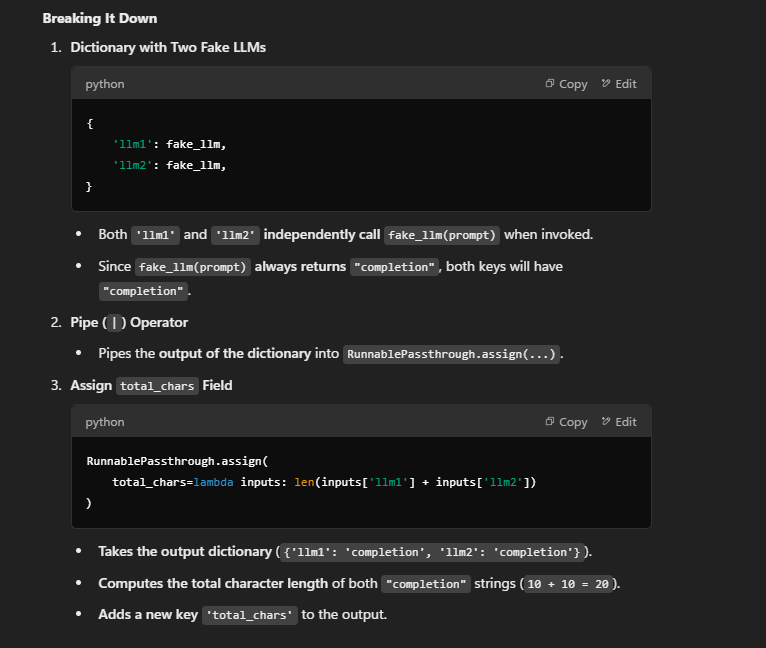
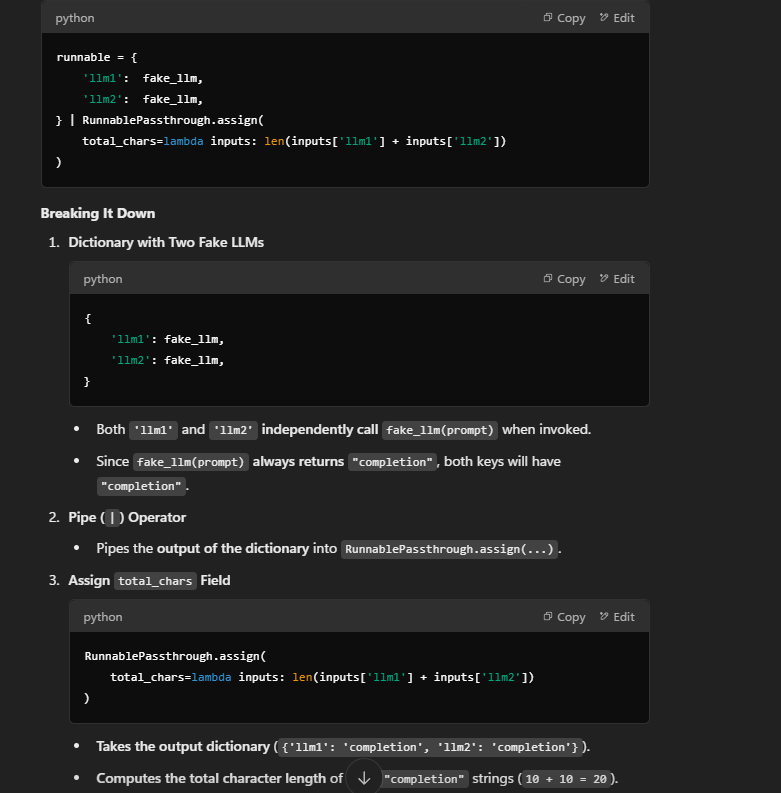

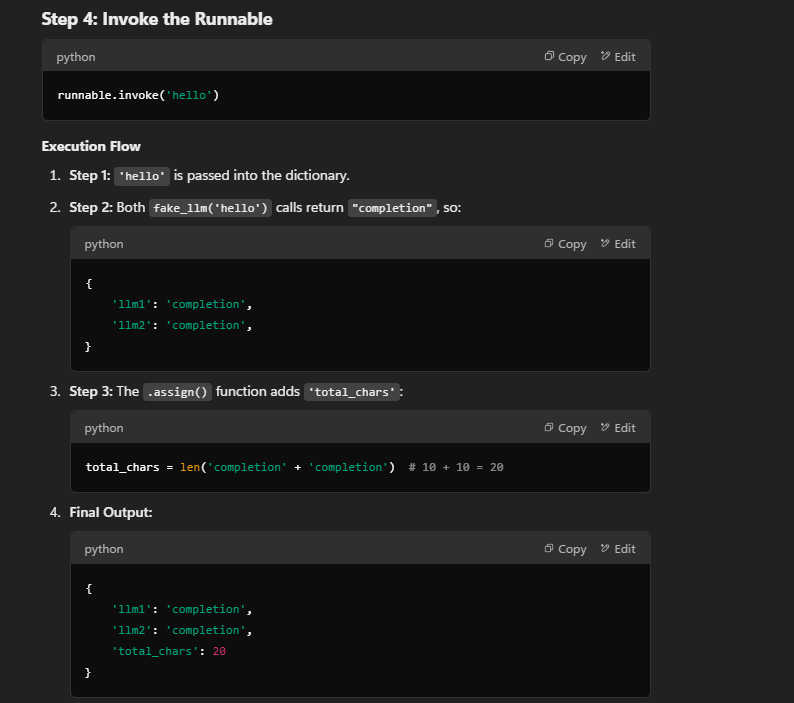

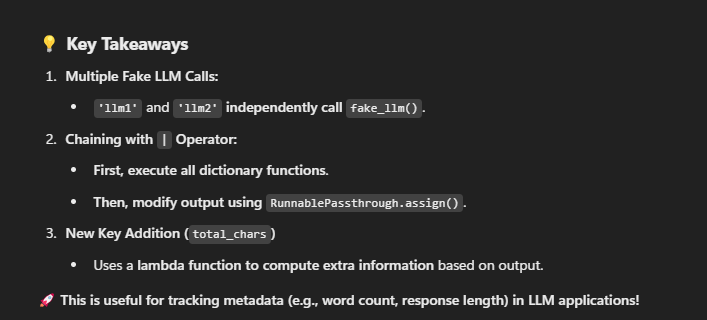

### Now Come to the Original Code

In [23]:
# lets create a function now which returns the list of messages from memory
def get_memory_messages(query):
    return memory.load_memory_variables(query)['history']

get_memory_messages('What are the first four colors of a rainbow?')

[]

In [24]:
type(RunnableLambda(get_memory_messages))

langchain_core.runnables.base.RunnableLambda

In [25]:
# testing out the function with a runnable lambda which will go into our chain
# this returns the history but we also need to send our current query to the prompt
RunnableLambda(get_memory_messages).invoke({'query': 'What are the first four colors of a rainbow?'})

[]

In [26]:
# we use a runnable passthrough to pass our current query untouched
# along with the history messages to the next step in the chain
RunnablePassthrough.assign(
        history=RunnableLambda(get_memory_messages)
    ).invoke({'query': 'What are the first four colors of a rainbow1?','query2':"sourav"})

{'query': 'What are the first four colors of a rainbow1?',
 'query2': 'sourav',
 'history': []}

In [27]:
chain1 = {
    'query': RunnableLambda(lambda x: x['query2'])
} |RunnablePassthrough.assign(
        history=RunnableLambda(get_memory_messages)
    )
chain1.invoke({'query1': 'What are the first four colors of a rainbow1?','query2':"sourav"})

{'query': 'sourav', 'history': []}

In [28]:
chain2 = {
    'query': RunnableLambda(lambda x: x['query1'])
} |RunnablePassthrough.assign(
        history=RunnableLambda(get_memory_messages)
    )

chain2.invoke({'query1': 'What are the first four colors of a rainbow1?','query2':"sourav"})

{'query': 'What are the first four colors of a rainbow1?', 'history': []}

In [29]:
runnable = RunnableLambda(lambda x: x['query1'])
runnable.invoke({'query1': 'What are the first four colors of a rainbow1?', 'query2': "sourav"})

'What are the first four colors of a rainbow1?'

In [30]:
chain = {
    'query': RunnableLambda(lambda x: x['query']), 
    'llm1':  fake_llm,
    'llm2':  fake_llm,
} | RunnablePassthrough.assign(
    history=RunnableLambda(get_memory_messages)
)

chain.invoke({'query': 'What are the first four colors of a rainbow1?'})

{'query': 'What are the first four colors of a rainbow1?',
 'llm1': 'completion',
 'llm2': 'completion',
 'history': []}

In [31]:
# creating our conversation chain now
def get_memory_messages(query):
    return memory.load_memory_variables(query)['history']

conversation_chain = (
    RunnablePassthrough.assign(
        history=RunnableLambda(get_memory_messages)
    ) # sends current query (input by user at runtime) and history messages to next step
      |
    prompt # creates prompt using the previous two variables
      |
    chatgpt # generates response using the prompt from previous step
)

In [32]:
query = {'query': 'What are the first four colors of a rainbow?'}
response = conversation_chain.invoke(query)
print(response)

content='The first four colors of a rainbow are red, orange, yellow, and green.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 30, 'total_tokens': 48, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'stop', 'logprobs': None} id='run-e2e214b1-72f7-474f-b2a5-75004e5fe7ec-0' usage_metadata={'input_tokens': 30, 'output_tokens': 18, 'total_tokens': 48, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [33]:
print(response.content)

The first four colors of a rainbow are red, orange, yellow, and green.


In [34]:
memory.load_memory_variables({})

{'history': []}

In [35]:
memory.save_context(query, {"output": response.content})

In [36]:
memory.load_memory_variables({})

{'history': [HumanMessage(content='What are the first four colors of a rainbow?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The first four colors of a rainbow are red, orange, yellow, and green.', additional_kwargs={}, response_metadata={})]}

In [37]:
query = {'query': 'and the other 3?'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

The other three colors of a rainbow are blue, indigo, and violet.


In [38]:
memory.load_memory_variables({})

{'history': [HumanMessage(content='What are the first four colors of a rainbow?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The first four colors of a rainbow are red, orange, yellow, and green.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='and the other 3?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The other three colors of a rainbow are blue, indigo, and violet.', additional_kwargs={}, response_metadata={})]}

In [39]:
query = {'query': 'Explain AI in 2 bullet points'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

- **Definition**: Artificial Intelligence (AI) refers to the simulation of human intelligence in machines programmed to think and learn, enabling them to perform tasks that typically require human cognitive functions, such as problem-solving, understanding language, and recognizing patterns.

- **Applications**: AI is used in various fields, including healthcare (diagnosis and treatment recommendations), finance (fraud detection and algorithmic trading), autonomous vehicles, customer service (chatbots), and many more, enhancing efficiency and decision-making.


In [40]:
query = {'query': 'Now do the same for Deep Learning'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

- **Definition**: Deep Learning is a subset of machine learning that uses neural networks with many layers (deep neural networks) to model complex patterns in large datasets, enabling machines to learn from data in a way that mimics human brain function.

- **Applications**: Deep Learning is widely used in image and speech recognition, natural language processing, autonomous systems, and recommendation systems, driving advancements in technologies like virtual assistants, self-driving cars, and medical imaging analysis.


In [41]:
query = {'query': 'What have we discussed so far?'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

So far, we have discussed the following topics:

1. The first four colors of a rainbow (red, orange, yellow, green) and the remaining three (blue, indigo, violet).
2. A brief explanation of Artificial Intelligence (AI) in two bullet points.
3. A brief explanation of Deep Learning in two bullet points.


In [42]:
memory.load_memory_variables({})

{'history': [HumanMessage(content='What are the first four colors of a rainbow?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The first four colors of a rainbow are red, orange, yellow, and green.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='and the other 3?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The other three colors of a rainbow are blue, indigo, and violet.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Explain AI in 2 bullet points', additional_kwargs={}, response_metadata={}),
  AIMessage(content='- **Definition**: Artificial Intelligence (AI) refers to the simulation of human intelligence in machines programmed to think and learn, enabling them to perform tasks that typically require human cognitive functions, such as problem-solving, understanding language, and recognizing patterns.\n\n- **Applications**: AI is used in various fields, including healthcare (diagnosis and treatmen

### Conversation Chains with ConversationBufferWindowMemory

If you have a really long conversation, you might exceed the max token limit of the context window allowed for the LLM when using `ConversationBufferMemory` so `ConversationBufferWindowMemory` helps in just storing the last K conversations (one conversation piece is one user message and the corresponding AI message from the LLM) and thus helps you manage token limits and costs

In [43]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.memory import ConversationBufferWindowMemory
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda

SYS_PROMPT = """Act as a helpful assistant and give brief answers"""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{query}"),
    ]
)

# stores last 2 sets of human-AI conversations
memory = ConversationBufferWindowMemory(return_messages=True, k=2)

# creating our conversation chain now
def get_memory_messages(query):
    return memory.load_memory_variables(query)['history']

conversation_chain = (
    RunnablePassthrough.assign(
        history=RunnableLambda(get_memory_messages)
    ) # sends current query (input by user at runtime) and history messages to next step
      |
    prompt # creates prompt using the previous two variables
      |
    chatgpt # generates response using the prompt from previous step
)

C:\Users\Sourav Banerjee\AppData\Local\Temp\ipykernel_45028\96416143.py:15: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferWindowMemory(return_messages=True, k=2)


In [44]:
query = {'query': 'What are the first four colors of a rainbow?'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

The first four colors of a rainbow are red, orange, yellow, and green.


In [45]:
query = {'query': 'and the other 3?'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

The other three colors of a rainbow are blue, indigo, and violet.


In [46]:
query = {'query': 'Explain AI in 2 bullet points'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

- **Definition**: Artificial Intelligence (AI) refers to the simulation of human intelligence in machines programmed to think and learn, enabling them to perform tasks that typically require human cognitive functions, such as problem-solving, understanding language, and recognizing patterns.

- **Applications**: AI is used in various fields, including healthcare (diagnosis and treatment recommendations), finance (fraud detection and algorithmic trading), autonomous vehicles, customer service (chatbots), and more, enhancing efficiency and decision-making.


In [47]:
query = {'query': 'Now do the same for Deep Learning'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

- **Definition**: Deep Learning is a subset of machine learning that uses neural networks with many layers (deep neural networks) to model complex patterns in large datasets, enabling machines to learn from data in a way that mimics human brain function.

- **Applications**: Deep Learning is widely used in image and speech recognition, natural language processing, autonomous systems, and generative models, driving advancements in technologies like virtual assistants, facial recognition, and self-driving cars.


In [48]:
memory.load_memory_variables({})

{'history': [HumanMessage(content='Explain AI in 2 bullet points', additional_kwargs={}, response_metadata={}),
  AIMessage(content='- **Definition**: Artificial Intelligence (AI) refers to the simulation of human intelligence in machines programmed to think and learn, enabling them to perform tasks that typically require human cognitive functions, such as problem-solving, understanding language, and recognizing patterns.\n\n- **Applications**: AI is used in various fields, including healthcare (diagnosis and treatment recommendations), finance (fraud detection and algorithmic trading), autonomous vehicles, customer service (chatbots), and more, enhancing efficiency and decision-making.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Now do the same for Deep Learning', additional_kwargs={}, response_metadata={}),
  AIMessage(content='- **Definition**: Deep Learning is a subset of machine learning that uses neural networks with many layers (deep neural networks) t

In [49]:
query = {'query': 'What have we discussed so far?'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

So far, we have discussed the concepts of Artificial Intelligence (AI) and Deep Learning, including their definitions and applications.


In [50]:
memory.load_memory_variables({})

{'history': [HumanMessage(content='Now do the same for Deep Learning', additional_kwargs={}, response_metadata={}),
  AIMessage(content='- **Definition**: Deep Learning is a subset of machine learning that uses neural networks with many layers (deep neural networks) to model complex patterns in large datasets, enabling machines to learn from data in a way that mimics human brain function.\n\n- **Applications**: Deep Learning is widely used in image and speech recognition, natural language processing, autonomous systems, and generative models, driving advancements in technologies like virtual assistants, facial recognition, and self-driving cars.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What have we discussed so far?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='So far, we have discussed the concepts of Artificial Intelligence (AI) and Deep Learning, including their definitions and applications.', additional_kwargs={}, response_metadat

### Conversation Chains with ConversationSummaryMemory

If you have a really long conversation or a lot of messages, you might exceed the max token limit of the context window allowed for the LLM when using `ConversationBufferMemory`

`ConversationSummaryMemory` creates a summary of the conversation history over time. This can be useful for condensing information from the conversation messages over time.

This memory is most useful for longer conversations, where keeping the past message history in the prompt verbatim would take up too many tokens.

In [51]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.memory import ConversationSummaryMemory
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda

SYS_PROMPT = """Act as a helpful assistant and give brief answers"""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{query}"),
    ]
)

memory = ConversationSummaryMemory(return_messages=True, llm=chatgpt)
# creating our conversation chain now
def get_memory_messages(query):
    return memory.load_memory_variables(query)['history']

conversation_chain = (
    RunnablePassthrough.assign(
        history=RunnableLambda(get_memory_messages)
    ) # sends current query (input by user at runtime) and history messages as a summary to next step
      |
    prompt # creates prompt using the previous two variables
      |
    chatgpt # generates response using the prompt from previous step
)

C:\Users\Sourav Banerjee\AppData\Local\Temp\ipykernel_45028\2640930987.py:14: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationSummaryMemory(return_messages=True, llm=chatgpt)


In [52]:
query = {'query': 'Explain AI in 2 bullet points'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

- **Definition**: Artificial Intelligence (AI) refers to the simulation of human intelligence processes by machines, particularly computer systems, enabling them to perform tasks such as learning, reasoning, and problem-solving.

- **Applications**: AI is used in various fields, including healthcare (diagnosis and treatment recommendations), finance (fraud detection), autonomous vehicles, customer service (chatbots), and more, enhancing efficiency and decision-making.


In [53]:
query = {'query': 'Now do the same for Deep Learning'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

- Deep learning is a subset of machine learning that uses neural networks with many layers to analyze and interpret complex data patterns, enabling tasks like image and speech recognition.
- It is widely applied in areas such as natural language processing, computer vision, and autonomous systems, significantly improving performance in these fields.


In [54]:
memory.load_memory_variables({})

{'history': [SystemMessage(content='The human asks the AI to explain artificial intelligence in two bullet points. The AI defines artificial intelligence as the simulation of human intelligence processes by machines, enabling tasks like learning and problem-solving, and notes its applications in fields such as healthcare, finance, autonomous vehicles, and customer service, enhancing efficiency and decision-making. The human then requests a similar explanation for deep learning, to which the AI responds that deep learning is a subset of machine learning using neural networks with many layers to analyze complex data patterns, enabling tasks like image and speech recognition, and that it is widely applied in natural language processing, computer vision, and autonomous systems, significantly improving performance in these areas.', additional_kwargs={}, response_metadata={})]}

In [55]:
query = {'query': 'What have we discussed so far?'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

We discussed artificial intelligence (AI) and deep learning. AI is the simulation of human intelligence processes by machines, with applications in various fields like healthcare and finance. Deep learning is a subset of machine learning that uses neural networks to analyze complex data patterns, applied in areas like image recognition and natural language processing.


### Conversation Chains with VectorStoreRetrieverMemory

`VectorStoreRetrieverMemory` stores historical conversation messages in a vector store and queries the top-K most "relevant" history messages every time it is called.

This differs from most of the other Memory classes in that it doesn't explicitly track the order of interactions but retrieves history based on embedding similarity to the current question or prompt.

In this case, the "docs" are previous conversation snippets. This can be useful to refer to relevant pieces of information that the AI was told earlier in the conversation.

#### Connect to  Open AI Embedding Models

LangChain enables us to access Open AI embedding models which include the newest models: a smaller and highly efficient `text-embedding-3-small` model, and a larger and more powerful `text-embedding-3-large` model.

In [56]:
from langchain_openai import OpenAIEmbeddings

# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

#### Create a Vector Database to store conversation history

Here we use the Chroma vector DB and initialize an empty database collection to store conversation messages

In [57]:
from langchain_chroma import Chroma

# create empty vector DB
chroma_db = Chroma(collection_name='history_db',
                   embedding_function=openai_embed_model)

ModuleNotFoundError: No module named 'langchain_chroma'

In [0]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.memory import VectorStoreRetrieverMemory
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda

SYS_PROMPT = """Act as a helpful assistant and give brief answers"""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{query}"),
    ]
)

# load 2 most similar conversation messages from vector db history for each new message \ prompt
# this uses cosine embedding similarity to load the top 2 similar messgages to the input prompt \ query
retriever = chroma_db.as_retriever(search_type="similarity",
                                   search_kwargs={"k": 2})
memory = VectorStoreRetrieverMemory(retriever=retriever, return_messages=True)

# creating our conversation chain now
def get_memory_messages(query):
    return [memory.load_memory_variables(query)['history']]

conversation_chain = (
    RunnablePassthrough.assign(
        history=RunnableLambda(get_memory_messages)
    ) # sends current query (input by user at runtime) and history messages to next step
      |
    prompt # creates prompt using the previous two variables
      |
    chatgpt # generates response using the prompt from previous step
)

/tmp/ipykernel_633820/573889585.py:18: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = VectorStoreRetrieverMemory(retriever=retriever, return_messages=True)


In [ ]:
query = {'query': 'Tell me about AI'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

- Artificial Intelligence (AI) is the simulation of human intelligence processes by machines, allowing them to perform tasks such as learning, reasoning, and problem-solving.
- AI is applied in various fields, including healthcare, finance, autonomous vehicles, and customer service, enhancing efficiency and decision-making.


In [ ]:
query = {'query': 'What about deep learning'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

- Deep learning is a subset of machine learning that utilizes neural networks with multiple layers to analyze and interpret complex data patterns.
- It is widely used in applications such as image and speech recognition, natural language processing, and medical diagnosis, significantly improving accuracy and performance.


In [ ]:
query = {'query': 'Tell me about the fastest animal in the world in 2 lines'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

The fastest animal in the world is the peregrine falcon, which can reach speeds over 240 mph (386 km/h) during its hunting stoop (high-speed dive). On land, the cheetah holds the record, capable of sprinting up to 60-70 mph (97-113 km/h) in short bursts.


In [ ]:
query = {'query': 'What about the cheetah?'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

The cheetah is the fastest land animal, capable of sprinting at speeds of 60-70 mph (97-113 km/h) in short bursts covering distances up to 1,500 feet (460 meters). It is known for its incredible acceleration and agility, allowing it to catch prey quickly.


Now for a new query around machine learning even if the most recent conversation messages have been about animals, it uses the vector databases to load the last 2 historical conversations which are closest to the current question in terms of semantic similarity

In [ ]:
print(memory.load_memory_variables({'query': 'What about machine learning?'})['history'])

[SystemMessage(content='The human asks the AI to explain artificial intelligence in two bullet points. The AI defines artificial intelligence as the simulation of human intelligence processes by machines, enabling tasks like learning and problem-solving, and highlights its applications in fields such as healthcare, finance, autonomous vehicles, and customer service, which enhance efficiency and decision-making. The human then requests a similar explanation for deep learning, and the AI describes deep learning as a subset of machine learning that uses neural networks with many layers to analyze complex data patterns, enabling tasks like image and speech recognition, and notes its applications in natural language processing, autonomous systems, and medical diagnosis, significantly improving accuracy and performance in these areas. The human further asks about AI, and the AI reiterates that artificial intelligence is the simulation of human intelligence processes by machines, allowing the

In [0]:
query = {'query': 'What about machine learning?'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

Machine learning is a subset of artificial intelligence that focuses on the development of algorithms that allow computers to learn from and make predictions or decisions based on data. It involves training models on datasets to identify patterns and improve performance over time without being explicitly programmed for specific tasks. Machine learning is widely used in applications like recommendation systems, fraud detection, and predictive analytics.


### Multi-user Conversation Chains with ChatMessageHistory

The concept of `ChatHistory` refers to a class in LangChain which can be used to wrap an arbitrary chain. This `ChatHistory` will keep track of inputs and outputs of the underlying chain, and append them as messages to a message database. Future interactions will then load those messages and pass them into the chain as part of the input.

The beauty of `ChatMessageHistory` is that we can store separate conversation histories per user or session which is often the need for real-world chatbots which will be accessed by many users at the same time.

We use a `get_session_history` function which is expected to take in a `session_id` and return a Message History object. Everything is stored in memory. This `session_id` is used to distinguish between separate conversations, and should be passed in as part of the config when calling the new chain

In [0]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# used to retrieve conversation history from memory
# based on a specific user or session ID
history_store = {}
def get_session_history(session_id):
    if session_id not in history_store:
        history_store[session_id] = ChatMessageHistory()
    return history_store[session_id]

# prompt to load in history and current input from the user
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "Act as a helpful AI Assistant"),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{human_input}"),
    ]
)

# create a basic LLM Chain
llm_chain = (prompt_template
                |
             chatgpt)

# create a conversation chain which can load memory based on specific user or session id
conv_chain = RunnableWithMessageHistory(
    llm_chain,
    get_session_history,
    input_messages_key="human_input",
    history_messages_key="history",
)

# create a utility function to take in current user input prompt and their session ID
# streams result live back to the user from the LLM
def chat_with_llm(prompt: str, session_id: str):
    for chunk in conv_chain.stream({"human_input": prompt},
                                   {'configurable': { 'session_id': session_id}}):
        print(chunk.content, end="")

Test conversation chain for user 1

In [0]:
user_id = 'bob123'
prompt = "Hi I am Bob, can you explain AI in 3 bullet points?"
chat_with_llm(prompt, user_id)

Sure, Bob! Here are three key points about AI:

1. **Definition and Purpose**: Artificial Intelligence (AI) refers to the simulation of human intelligence in machines that are programmed to think and learn. Its primary purpose is to perform tasks that typically require human intelligence, such as problem-solving, understanding natural language, and recognizing patterns.

2. **Types of AI**: AI can be categorized into two main types: Narrow AI, which is designed for specific tasks (like virtual assistants or recommendation systems), and General AI, which aims to understand and reason across a wide range of tasks, similar to human cognitive abilities (though this is still largely theoretical).

3. **Applications**: AI is used in various fields, including healthcare (for diagnostics and personalized medicine), finance (for fraud detection and algorithmic trading), transportation (in autonomous vehicles), and customer service (through chatbots and virtual agents), among many others.

In [0]:
prompt = "Now do the same for deep learning"
chat_with_llm(prompt, user_id)

Of course, Bob! Here are three key points about deep learning:

1. **Definition and Structure**: Deep learning is a subset of machine learning that uses neural networks with many layers (hence "deep") to model complex patterns in large datasets. These neural networks are inspired by the structure and function of the human brain.

2. **Learning Process**: Deep learning algorithms learn from vast amounts of data through a process called training, where they adjust their internal parameters to minimize the difference between their predictions and the actual outcomes. This allows them to automatically extract features and improve their performance over time.

3. **Applications**: Deep learning has led to significant advancements in various fields, including image and speech recognition, natural language processing, and game playing (like AlphaGo). It powers technologies such as facial recognition systems, language translation services, and self-driving cars.

In [0]:
prompt = "Discuss briefly what have we discussed so far is bullet points?"
chat_with_llm(prompt, user_id)

Certainly! Here’s a brief summary of what we’ve discussed so far in bullet points:

### Artificial Intelligence (AI)
- **Definition and Purpose**: AI simulates human intelligence in machines to perform tasks that require cognitive functions.
- **Types of AI**: Includes Narrow AI (specific tasks) and General AI (broad cognitive abilities, mostly theoretical).
- **Applications**: Used in healthcare, finance, transportation, and customer service, among other fields.

### Deep Learning
- **Definition and Structure**: A subset of machine learning using deep neural networks to model complex patterns in data.
- **Learning Process**: Involves training on large datasets to automatically extract features and improve predictions.
- **Applications**: Powers advancements in image/speech recognition, natural language processing, and technologies like facial recognition and self-driving cars.

Now test conversation chain for user 2

In [0]:
user_id = 'james007'
prompt = "Hi can you explain what is an LLM in 2 bullet points?"
chat_with_llm(prompt, user_id)

Sure! Here are two key points about LLMs (Large Language Models):

- **Definition**: LLMs are advanced artificial intelligence models designed to understand, generate, and manipulate human language by processing vast amounts of text data, enabling them to perform tasks like translation, summarization, and conversation.

- **Architecture**: They typically use deep learning techniques, particularly transformer architectures, which allow them to capture complex patterns and relationships in language, making them highly effective for various natural language processing applications.

In [0]:
prompt = "Actually I meant in the context of AI?"
chat_with_llm(prompt, user_id)

Got it! Here’s a refined explanation of LLMs in the context of AI:

- **Large Language Models (LLMs)**: These are AI models that are trained on extensive datasets to understand and generate human-like text. They leverage deep learning techniques to predict the next word in a sentence, enabling them to perform a wide range of language-related tasks.

- **Applications**: LLMs are used in various applications, including chatbots, content generation, language translation, and sentiment analysis, making them valuable tools in fields like customer service, education, and creative writing.

In [0]:
prompt = "Summarize briefly what we have discussed so far?"
chat_with_llm(prompt, user_id)

We discussed Large Language Models (LLMs) in the context of AI, highlighting two main points: 

1. LLMs are advanced AI models trained on large datasets to understand and generate human-like text, utilizing deep learning techniques.
2. They have diverse applications, including chatbots, content generation, language translation, and sentiment analysis, making them useful in various fields.

In [0]:
user_id = 'bob123'
prompt = "Discuss briefly what have we discussed so far is bullet points?"
chat_with_llm(prompt, user_id)

Sure! Here’s a concise summary of our discussion in bullet points:

### Summary of Discussion
- **Artificial Intelligence (AI)**:
  - Simulates human intelligence in machines for cognitive tasks.
  - Includes Narrow AI (specific tasks) and General AI (theoretical broad abilities).
  - Applications span healthcare, finance, transportation, and customer service.

- **Deep Learning**:
  - A subset of machine learning using deep neural networks to analyze complex data.
  - Involves training on large datasets to enhance feature extraction and predictions.
  - Applications include image/speech recognition, natural language processing, and technologies like facial recognition and autonomous vehicles.

### Multi-user Window-based Conversation Chains with persistence - SQLChatMessageHistory

The beauty of `SQLChatMessageHistory` is that we can store separate conversation histories per user or session which is often the need for real-world chatbots which will be accessed by many users at the same time. Instead of in-memory we can store it in a SQL database which can be used to store a lot of conversations.

We use a `get_session_history` function which is expected to take in a `session_id` and return a Message History object. Everything is stored in a SQL database. This `session_id` is used to distinguish between separate conversations, and should be passed in as part of the config when calling the new chain

We also use a `memory_buffer_window` function to only use the top-K last historical conversations before sending it to the LLM, basically our own implementation of `ConversationBufferWindowMemory`

In [0]:
# removes the memory database file - usually not needed
# you can run this only when you want to remove all conversation histories
!rm memory.db

In [0]:
from langchain_community.chat_message_histories import SQLChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough

# used to retrieve conversation history from database
# based on a specific user or session ID
def get_session_history_db(session_id):
    return SQLChatMessageHistory(session_id, "sqlite:///memory.db")

# prompt to load in history and current input from the user
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "Act as a helpful AI Assistant"),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{human_input}"),
    ]
)

# create a memory buffer window function to return the last K conversations
def memory_buffer_window(messages, k=2):
    return messages[-(k+1):]

# create a basic LLM Chain which only sends the last K conversations per user
llm_chain = (
    RunnablePassthrough.assign(history=lambda x: memory_buffer_window(x["history"]))
      |
    prompt_template
      |
    chatgpt
)

In [0]:
# create a conversation chain which can load memory based on specific user or session id
conv_chain = RunnableWithMessageHistory(
    llm_chain,
    get_session_history_db,
    input_messages_key="human_input",
    history_messages_key="history",
)

# create a utility function to take in current user input prompt and their session ID
# streams result live back to the user from the LLM
def chat_with_llm(prompt: str, session_id: str):
    for chunk in conv_chain.stream({"human_input": prompt},
                                   {'configurable': { 'session_id': session_id}}):
        print(chunk.content, end="")

Test conversation chain for user 1

In [0]:
user_id = 'jim001'
prompt = "Hi can you tell me which is the fastest animal?"
chat_with_llm(prompt, user_id)

/home/santhosh/anaconda3/lib/python3.11/site-packages/langchain_core/runnables/history.py:608: LangChainDeprecationWarning: `connection_string` was deprecated in LangChain 0.2.2 and will be removed in 1.0. Use connection instead.
  message_history = self.get_session_history(


The fastest animal in the world is the peregrine falcon. When in a dive, it can reach speeds of over 240 miles per hour (386 kilometers per hour). If you're considering speed in level flight, the Brazilian free-tailed bat holds the record, flying at speeds of around 99 miles per hour (160 kilometers per hour). For land animals, the cheetah is the fastest, capable of running speeds up to 60-70 miles per hour (97-113 kilometers per hour) in short bursts.

In [0]:
prompt = "what about the slowest animal?"
chat_with_llm(prompt, user_id)

The slowest animal is often considered to be the three-toed sloth. It moves at an average speed of about 0.24 kilometers per hour (0.15 miles per hour) when climbing trees. In water, they can swim slightly faster, but they are still quite slow compared to many other animals. Another contender for the title of slowest animal is the garden snail, which moves at a speed of about 0.03 miles per hour (0.048 kilometers per hour). Both of these animals have adapted to their slow pace as part of their survival strategies.

In [0]:
prompt = "what about the largest animal?"
chat_with_llm(prompt, user_id)

The largest animal on Earth is the blue whale (*Balaenoptera musculus*). Blue whales can reach lengths of up to 100 feet (30 meters) or more and can weigh as much as 200 tons (approximately 181 metric tonnes). These magnificent marine mammals are not only the largest animals alive today but are also believed to be the largest animals to have ever existed on Earth, surpassing even the largest dinosaurs. Their immense size is supported by their diet, which primarily consists of tiny shrimp-like animals called krill.

In [0]:
prompt = "what topics have we discussed, show briefly as bullet points"
chat_with_llm(prompt, user_id)

Sure! Here are the topics we've discussed so far:

- The slowest animal (three-toed sloth and garden snail)
- The largest animal (blue whale)

Now test conversation chain for user 2

In [0]:
user_id = 'john005'
prompt = "Explain AI in 3 bullets to a child"
chat_with_llm(prompt, user_id)

Sure! Here are three simple points to explain AI to a child:

1. **Smart Helpers**: AI is like a smart robot or computer that can help us with tasks, like answering questions or playing games, by learning from lots of information.

2. **Learning from Experience**: Just like how you get better at something the more you practice, AI learns from examples and gets better at doing things over time.

3. **Talking and Understanding**: AI can understand what we say and even talk back to us, kind of like having a conversation with a friend who knows a lot of things!

In [0]:
prompt = "Now do the same for Generative AI"
chat_with_llm(prompt, user_id)

Of course! Here are three simple points to explain Generative AI to a child:

1. **Creative Robot**: Generative AI is like a creative robot that can make new things, like pictures, stories, or music, all by itself!

2. **Learning from Examples**: It learns by looking at lots of examples, like reading many books or seeing many drawings, so it can create something new that’s similar but different.

3. **Imagination in a Computer**: Just like you use your imagination to come up with fun ideas, Generative AI uses its "imagination" to invent cool stuff that we can enjoy!

In [0]:
prompt = "Now do the same for machine learning"
chat_with_llm(prompt, user_id)

Sure! Here are three simple points to explain machine learning to a child:

1. **Learning Like You**: Machine learning is when a computer learns from experience, just like you learn new things by practicing and trying again.

2. **Finding Patterns**: It looks at lots of information to find patterns, like how you notice that the sky is blue during the day or that ice cream is cold and sweet.

3. **Getting Better Over Time**: The more it practices, the better it gets at making decisions or predictions, like guessing what your favorite game is based on what you’ve played before!

In [0]:
prompt = "what topics have we discussed, show briefly as bullet points"
chat_with_llm(prompt, user_id)

Sure! Here are the topics we've discussed so far:

- **Generative AI**
  - Creative robot that makes new things
  - Learns from examples
  - Uses imagination to invent cool stuff

- **Machine Learning**
  - Learning from experience like a person
  - Finding patterns in information
  - Improving over time with practice